In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from scipy import stats
plt.style.use('ggplot')

In [2]:
def load_data(file_path):
    return pd.read_parquet(file_path)

In [3]:
products_file = '../data/olist_products_dataset.parquet'
orders_file = '../data/olist_orders_dataset.parquet'
order_items_file = '../data/olist_order_items_dataset.parquet'
customers_file = '../data/olist_customers_dataset.parquet'
geolocation_file = '../data/olist_geolocation_dataset.parquet'
payments_file = '../data/olist_order_payments_dataset.parquet'
reviews_file = '../data/olist_order_reviews_dataset.parquet'
sellers_file = '../data/olist_sellers_dataset.parquet'
category_file = '../data/product_category_name_translation.parquet'

In [4]:
products_df = load_data(products_file)
orders_df = load_data(orders_file)
order_items_df = load_data(order_items_file)
customers_df = load_data(customers_file)
geolocation_df = load_data(geolocation_file)
payments_df = load_data(payments_file)
reviews_df = load_data(reviews_file)
sellers_df = load_data(sellers_file)
category_df = load_data(category_file)

In [5]:
# Merge dos dataframes
orders_products = orders_df.merge(order_items_df, on='order_id', how='inner')
orders_products_customers = orders_products.merge(customers_df, on='customer_id', how='inner')
orders_products_customers_reviews = orders_products_customers.merge(reviews_df, on='order_id', how='inner')
orders_products_customers_reviews_payments = orders_products_customers_reviews.merge(payments_df, on='order_id', how='inner')
orders_products_customers_reviews_payments_sellers = orders_products_customers_reviews_payments.merge(sellers_df, on='seller_id', how='inner')
df = orders_products_customers_reviews_payments_sellers.merge(products_df, on='product_id', how='inner')
df = df.merge(category_df, on='product_category_name', how='inner')

In [6]:
def resumirtabela(df):
    print(f"Shape: {df.shape}")
    resumo = pd.DataFrame(df.dtypes, columns=['dtypes'])
    resumo = resumo.reset_index()
    resumo['Name'] = resumo['index']
    resumo = resumo[['Name', 'dtypes']]
    resumo['Missing'] = df.isnull().sum().values
    resumo['Uniques'] = df.nunique().values
    resumo['First Value'] = df.loc[0].values
    resumo['Second Value'] = df.loc[1].values
    resumo['Third Value'] = df.loc[2].values

    for name in resumo['Name'].value_counts().index:
        resumo.loc[resumo['Name'] == name, 'Entropy'] = round(
            stats.entropy(df[name].value_counts(normalize=True), base=2), 2)
    return resumo

In [7]:
resumirtabela(df)

Shape: (115609, 40)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,order_id,object,0,96516,e481f51cbdc54678b7cc49136f2d6af7,e481f51cbdc54678b7cc49136f2d6af7,e481f51cbdc54678b7cc49136f2d6af7,16.41
1,customer_id,object,0,96516,9ef432eb6251297304e76186b10a928d,9ef432eb6251297304e76186b10a928d,9ef432eb6251297304e76186b10a928d,16.41
2,order_status,object,0,7,delivered,delivered,delivered,0.18
3,order_purchase_timestamp,object,0,95989,2017-10-02 10:56:33,2017-10-02 10:56:33,2017-10-02 10:56:33,16.40
4,order_approved_at,object,14,88332,2017-10-02 11:07:15,2017-10-02 11:07:15,2017-10-02 11:07:15,16.24
5,order_delivered_carrier_date,object,1195,79241,2017-10-04 19:55:00,2017-10-04 19:55:00,2017-10-04 19:55:00,16.00
6,order_delivered_customer_date,object,2400,93702,2017-10-10 21:25:13,2017-10-10 21:25:13,2017-10-10 21:25:13,16.37
7,order_estimated_delivery_date,object,0,449,2017-10-18 00:00:00,2017-10-18 00:00:00,2017-10-18 00:00:00,8.47
8,order_item_id,int64,0,21,1,1,1,0.72
9,product_id,object,0,32171,87285b34884572647811a353c7ac498a,87285b34884572647811a353c7ac498a,87285b34884572647811a353c7ac498a,13.60


In [8]:
id_cols = [
    'order_id', 'seller_id', 'customer_id', 'order_item_id',
      'product_id', 'review_id', 'customer_unique_id', 'seller_zip_code_prefix']

cat_cols = df.nunique()[df.nunique() <= 27].keys().tolist()

num_cols = [x for x in df.columns if x not in cat_cols + id_cols]

bin_cols = df.nunique()[df.nunique() == 2].keys().tolist()

multi_cols = [i for i in cat_cols if i not in bin_cols]

## Distribuição dos preços

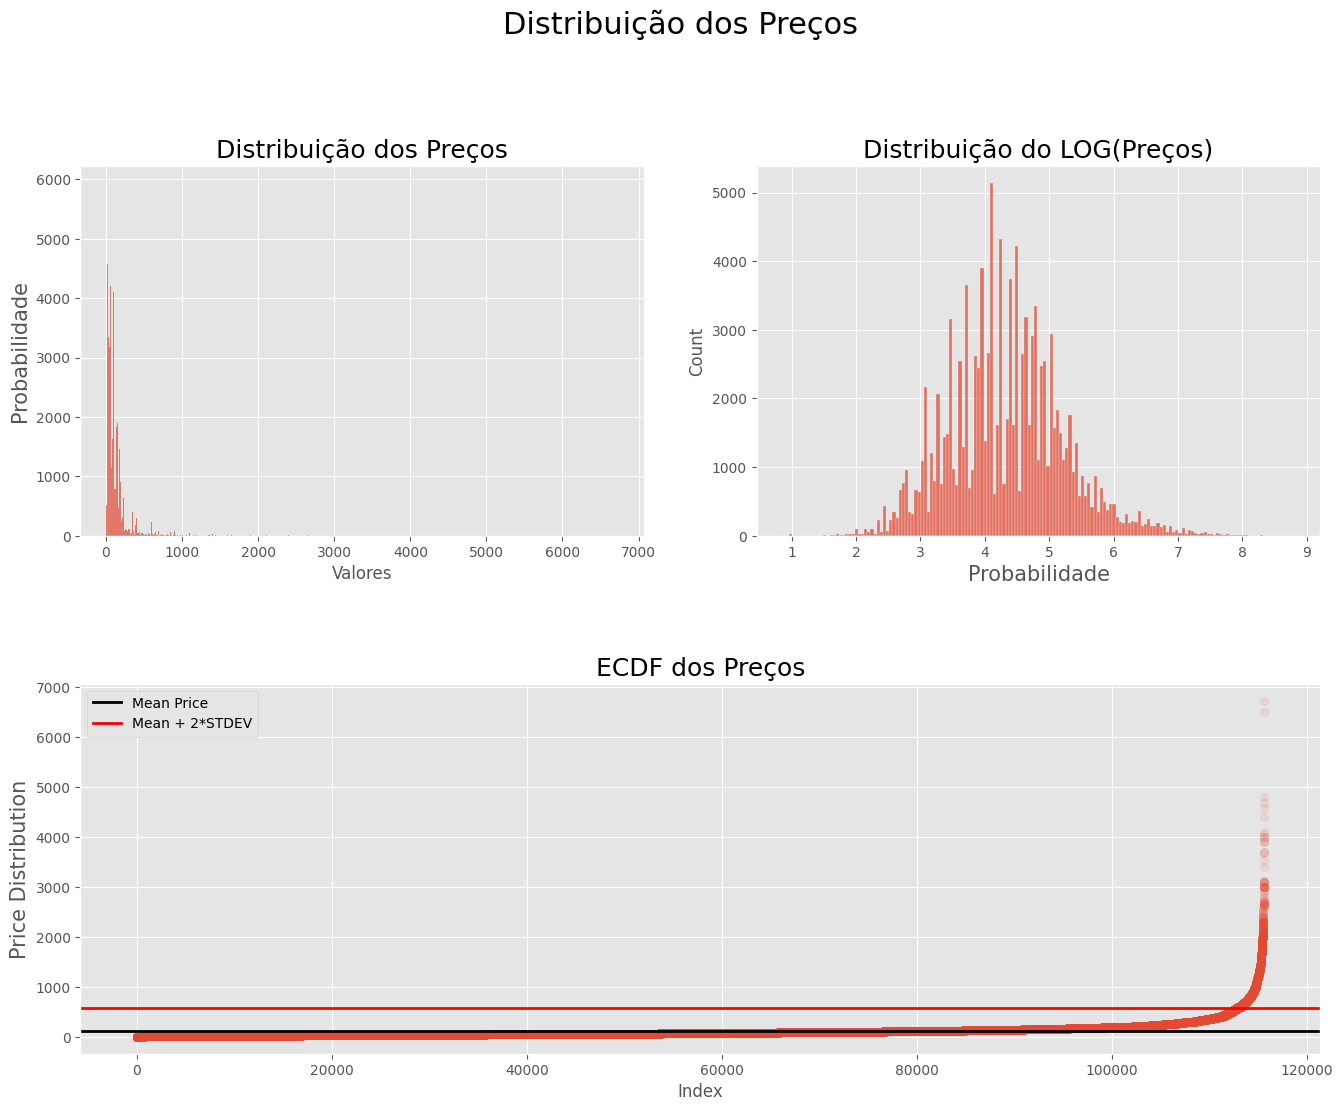

In [9]:
df.fillna({'price': -1}, inplace=True)

plt.figure(figsize=(16, 12))
plt.suptitle('Distribuição dos Preços', fontsize=22)
plt.subplot(221)
g = sns.histplot(df['price'])
g.set_title('Distribuição dos Preços', fontsize=18)
g.set_xlabel('Valores')
g.set_ylabel('Probabilidade', fontsize=15)

plt.subplot(222)
g1 = sns.histplot(np.log(df['price']+1.5))
g1.set_title("Distribuição do LOG(Preços)", fontsize=18)
g1.set_xlabel("Valores")
g1.set_xlabel("Probabilidade", fontsize=15)

plt.subplot(212)
g4 = plt.scatter(range(df.shape[0]),
                 np.sort(df['price']. values),
                 alpha=.1)
g4 = plt.title("ECDF dos Preços", fontsize=18)
g4 = plt.xlabel("Index")
g4 = plt.ylabel("Price Distribution", fontsize=15)
g4 = plt.axhline(df[df['price'] != -1]['price'].mean(), color='black',
                 label='Mean Price', linewidth=2)
g4 = plt.axhline(df[df['price'] != -1]['price'].mean() + (2.5*df[df['price'] != -1]['price'].std()),
                 color='red', label='Mean + 2*STDEV', linewidth=2)
g4 = plt.legend()

plt.subplots_adjust(hspace=0.4, top=0.85)

plt.show()

In [10]:
media_precos = df['price'].mean()
desvio_padrao_precos = df['price'].std()
print(f"Média dos preços é: {media_precos}\nDesvio Padrão é: {desvio_padrao_precos}")

Média dos preços é: 120.61984957918503
Desvio Padrão é: 182.6534760260345


# Tipos de Pagamento

In [11]:
df['price_log'] = np.log(df['price'] + 1.5)

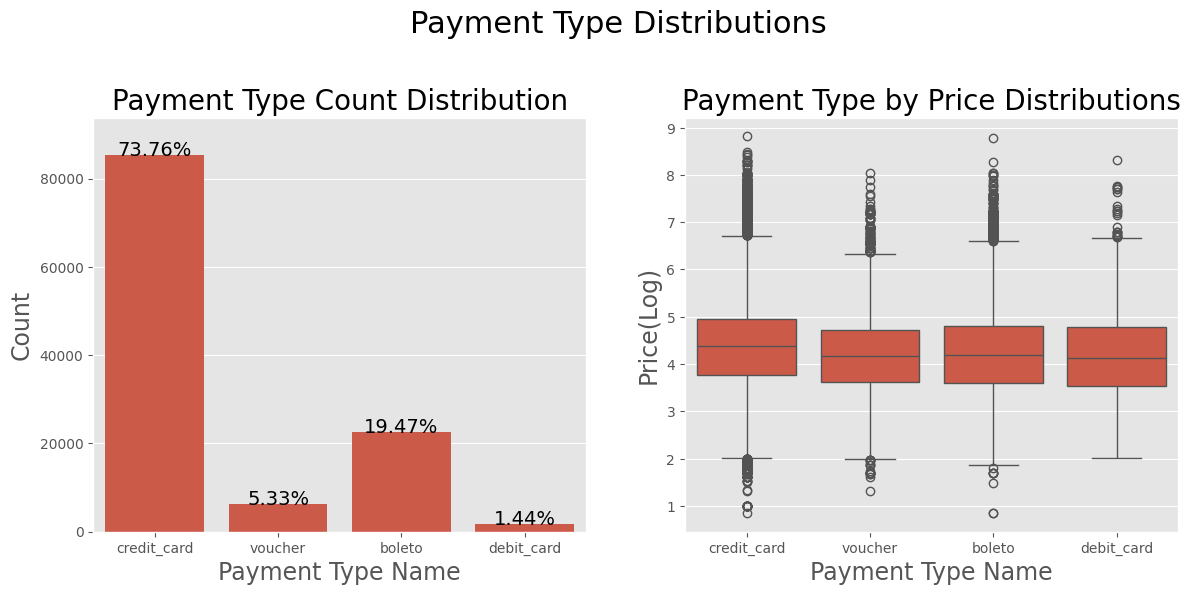

In [12]:
total = len(df)

plt.figure(figsize=(14,6))

plt.suptitle('Payment Type Distributions', fontsize=22)

plt.subplot(121)
g = sns.countplot(x='payment_type', data=df[df['payment_type'] != 'not_defined'])
g.set_title("Payment Type Count Distribution", fontsize=20)
g.set_xlabel("Payment Type Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)

sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
    
g.set_ylim(0, max(sizes) * 1.1)

plt.subplot(122)
g = sns.boxplot(x='payment_type', y='price_log', data=df[df['payment_type'] != 'not_defined'])
g.set_title("Payment Type by Price Distributions", fontsize=20)
g.set_xlabel("Payment Type Name", fontsize=17)
g.set_ylabel("Price(Log)", fontsize=17)

plt.subplots_adjust(hspace = 0.5, top = 0.8)

plt.show()